In [140]:
import numpy as np
import pandas as pd
import math
import argparse
import sys
import copy
import time
import random
import os
import matplotlib.pyplot as plt

Set Hyperparameters for GA, which include population, elite rate and crossover rate etc.

In [159]:
parser = argparse.ArgumentParser()
parser.add_argument('--population', default=100, type=int)
parser.add_argument('--elite_rate', default=0.2, type=float)
parser.add_argument('--mutation_rate', default=0.2, type=float)
parser.add_argument('--crossover_rate', default=0.6, type=float)
parser.add_argument('--iteration', default=10, type=int)
parser.add_argument('--N_chr', default=10, type=int)

_StoreAction(option_strings=['--N_chr'], dest='N_chr', nargs=None, const=None, default=10, type=<class 'int'>, choices=None, help=None, metavar=None)

Set variables for experimental environment, like the wind speed and the scale of land.

In [142]:
ws = 16 # wind speed
length = 2000 # width and length
wake = 0.094 # wake decay coff
air = 1.225 # air density
Cef = 0.4 # eff
Ct= 0.88 # thrust coff
start_time = time.time()
global  pr ,D , H ,N_r,recorded_best_fitness,time_recorded

Set the parameters of turbines, include the Diameter of turbine and the height of trubine.

In [143]:
def read_data():
    global  pr ,D , H, N_r
    pr = 2 #megawatt
    D = 63.6 #Diameter
    H = 60 #Height
    N_r = int(math.floor(length / (5*D)))

Get a initial grid with 36 possible locations of turbine (6x6)

In [144]:
def Grid(D):
    grid_layout = np.zeros((N_r,N_r))
    return grid_layout

Function that calculates the Cost of wind farm per year

In [145]:
def Cost(N_turbines):
    #c= (N_turbines)*((1170*pr)+(1.5 * ( (0.016) * (D**2.8) * ((H/D)**(1.7)) * ((pr/A)**(0.6)))))
    c = (N_turbines * ((2./3)+((1./3) * (np.exp((-0.00174*((N_turbines)**2)))))))
    return c

In [146]:
def Wake_effect(grid_layout):
    A = (3.14) * ((D/2)**2) 
    P_matrix = np.zeros((N_r,N_r))
    Vdf = np.zeros((N_r,N_r))
    Dwk = np.zeros((N_r,N_r))
    for i in range(N_r):
        for j in range(N_r):
            if j==0 and grid_layout[i][j] == 1:
                P_matrix [i][j]=0.5* air * A * Cef * (ws**3)# * (10**-6) #megawatt
            else:    
                if(grid_layout[i][j] == 1):
                    c_j = j
                    c_empty = 0
                    while c_j > 0:
                        if grid_layout[i][c_j-1] == 0 :
                            c_empty +=1
                        else:
                            break
                        c_j=c_j-1
                    s= 5.*D + ((5.*D)*c_empty)
                    Dwk[i][j]=D +  (2 * wake * s)
                    Vdf[i][j]=ws * ((1 - (math.sqrt(1-Ct))) * ((D/(Dwk[i][j]))**2))
                    P_matrix [i][j]=0.5 * air * A * Cef * ((ws-Vdf[i][j])**3)        
                        
                else:
                    Vdf[i][j] = 0
                    P_matrix[i][j] = 0           
    return P_matrix 

Function that calculates the power produced by wind farm per year.

In [147]:
def Power(P_matrix):
    p_total = np.sum(P_matrix ) *0.001
    return p_total

objective function, which can be represented as cost(per year)/power(per year)

In [148]:
def Obj_func (grid_layout ):
    cou = 0
    for i in range (N_r):
        for j in range (N_r):
            if grid_layout[i][j]==1:
                cou=cou+1 
    P_matrix = Wake_effect(grid_layout)
    pow = Power(P_matrix)
    co = Cost(cou)
    obj = co/pow
    return obj

Get a random solution for test

In [149]:
def random_sol(grid,N_turbines):
    no_ones =0
    while no_ones < N_turbines :
        for i in range(N_r):
            if no_ones == N_turbines :
                    break
            for j in range(N_r):
                if no_ones == N_turbines :
                    break
                if random.uniform(0,1) < 0.7 and grid[i][j]!=1:
                    grid[i][j]=1
                    no_ones +=1
                else:
                    grid[i][j]=0
                 
    return grid

Selection process of GA, here we used elitist selection. It is one of the most basic selection strategies. The idea of this strategy is to copy the best individuals (called elite individuals) that have appeared so far in the evolutionary process of the population to the next generation without crossing. 

In [150]:
def Selection(G):
    fitness_arr=[]
    sorted_chr=[]
    for i in range(len(G)) :
        fitness_arr.append(Obj_func(G[i]))
    sort=sorted(fitness_arr)

    for i in range (len(G)):
        for j in range(len(G)):
            if sort[i]==Obj_func(G[j]):
                sorted_chr.append(G[j])
                break


    return sorted_chr

Crossover process of GA. In this problem, we used two different parent generated by selection and Single point crossing to crossover parents and generate a new individual.

In [151]:
def Crossover(sorted_chr,Cp):
    n_children_cross=int(Cp*len(sorted_chr))
    global crossover
    crossover = []
    sorted_temp = copy.deepcopy(sorted_chr)
    i=0
    while(i<n_children_cross):
        temp1 = copy.deepcopy(sorted_temp[i])
        temp2 = copy.deepcopy(sorted_temp[i+1])
        for j in range (len(sorted_chr[i])):
            if np.random.rand()<0.7:
                temp_row= copy.copy(temp1[j])
                temp1[j] = temp2[j]
                temp2[j] = temp_row
        if Obj_func(temp1) < Obj_func(temp2):
            crossover.append(temp1)
        else:
            crossover.append(temp2)
        i = i +1
    return crossover

Mutation process of GA, we used uniform mutation. We set specific variation quantity Mp for offspring individuals, that randomly selected N genes in chromosomes for variation (change 0 to 1, and 1 to 0).

In [152]:
def Mutation(sorted_chr,Mp):
    n_mutated=int(Mp*len(sorted_chr))
    i = len(sorted_chr)-1
    counter = 0
    mutated = []
    temp = copy.deepcopy(sorted_chr)

    while(counter < n_mutated):
        for j in range(N_r):
            for k in range(N_r):
                t = np.random.rand()
                if t < 0.5:
                    if temp[i][j][k] ==1:
        #               print temp[i][j][k] 
                        temp[i][j][k] =0
        #               print temp[i][j][k]    
                    else :
                        temp[i][j][k] = 1


        mutated.append(temp[i])
        i=i-1
        counter = counter+1               
    return mutated        
         

Genetic Algorithm Function

In [153]:
def GA(population,N_chr,iteration,Mp,Cp,Ep):
    global recorded_best_fitness,time_recorded,G,Best_sols_ever,best_so_far_sol
    read_data()
    G=[]
    best_so_far_sol=[]
    best_so_far_fitness = 1000
    recorded_best_fitness = []

    time_recorded =[]
    for f in range(iteration):
        G=[]
        N_turbines = random.randint((N_r**2)//2,N_r**2)
        print ("This is iteration No", f)
        for i in range(N_chr):
            grid_layout=Grid(D)
            initial_solution = random_sol(grid_layout,N_turbines)
            G.append(initial_solution)
        for i in range (population):
            sorting=Selection(G)
            Best_sols_ever=[]
            for j in range (int(Ep*len(G))):
                Best_sols_ever.append(sorting[j])
            Crossedover=Crossover(sorting,Cp)
            for q in range (len(Crossedover)):
                Best_sols_ever.append(Crossedover[q])

            Mutated=Mutation(sorting,Mp)
            for k in range (len(Mutated)):
                Best_sols_ever.append(Mutated[k])

            Best_sols_ever = Selection(Best_sols_ever)
            if Obj_func(Best_sols_ever[0]) < best_so_far_fitness:
                best_so_far_sol = Best_sols_ever[0]
                best_so_far_fitness = Obj_func(best_so_far_sol)   
                print ("The Best So far solution",best_so_far_fitness)
            recorded_best_fitness.append(best_so_far_fitness)
            r_b_f.append(recorded_best_fitness)
            time_recorded.append((time.time()-start_time)/60)
            
    plt.plot(recorded_best_fitness)
    plt.title("GA with 10 samples")
#     f=plt.gcf()
#     pic_dir = "pics"
#     f.savefig(os.path.join(pic_dir,'GA_run_10.jpg'),dpi=500)
    return best_so_far_sol

Show the results, and save them in current file

In [154]:
def show_result(iteration_number,fit,num_tub,total_power,total_cost,best_sols,best_time):
    xfile_name = "Run%d.txt" % iteration_number
    with open(xfile_name, "w") as xf:
        xf.write("The best Fittness is "+repr(fit)+ ".\n")
        xf.write("****************************************\n")
        xf.write("The best Number of turbines is "+repr(num_tub)+ ".\n")
        xf.write("****************************************\n")
        xf.write("The Total power is "+ repr(total_power)+ ".\n")
        xf.write("****************************************\n")
        xf.write("The Total cost is "+repr(total_cost)+ ".\n")
        xf.write("****************************************\n")
        xf.write("The Recoreded best solutions are \n"+repr(best_sols)+ ".\n")
        xf.write("****************************************\n")
        xf.write("The time over iterations\n"+ repr(best_time)+ ".\n")
        xf.write("****************************************\n")

In [155]:
def main(args):
    
    for i in range(20):
        best = GA(args.population,args.N_chr,args.iteration,args.mutation_rate,args.crossover_rate,args.elite_rate)
        countt = 0
        for j in range (N_r):
            for k in range (N_r):
                if best[j][k]==1:
                    countt=countt+1 
        best_fit = Obj_func(best)
        p_m=Wake_effect(best)   
        Total_power = Power(p_m)
        Total_cost =Cost(countt)
        show_result(i,best_fit,countt,Total_power,Total_cost,recorded_best_fitness,time_recorded)

This is iteration No 0
The Best So far solution 0.00035152069004215473
The Best So far solution 0.0003499767950974094
The Best So far solution 0.0003416322175477282
The Best So far solution 0.0003361475135006463
The Best So far solution 0.00033136144545528433
This is iteration No 1
The Best So far solution 0.00032952989863964307
The Best So far solution 0.00032868804454082377
The Best So far solution 0.00032266476296987826
This is iteration No 2
This is iteration No 3
This is iteration No 4
This is iteration No 5
This is iteration No 6
This is iteration No 7
This is iteration No 8
This is iteration No 9
This is iteration No 0
The Best So far solution 0.0003410897544739513
The Best So far solution 0.000338798125414245
The Best So far solution 0.00033811811074592815
The Best So far solution 0.00032956083441639054
The Best So far solution 0.0003268350676339971
This is iteration No 1
The Best So far solution 0.000323007221765706
The Best So far solution 0.0003211882340113238
This is iterat

This is iteration No 8
This is iteration No 9
This is iteration No 0
The Best So far solution 0.0003319156942526242
The Best So far solution 0.00033174284757409657
The Best So far solution 0.0003299105936299768
The Best So far solution 0.0003281521947792245
The Best So far solution 0.0003267386738040656
The Best So far solution 0.00032466011873077646
This is iteration No 1
This is iteration No 2
The Best So far solution 0.0003233812172070533
This is iteration No 3
The Best So far solution 0.00032152058977310947
This is iteration No 4
This is iteration No 5
This is iteration No 6
This is iteration No 7
This is iteration No 8
This is iteration No 9
This is iteration No 0
The Best So far solution 0.000339533771207836
The Best So far solution 0.0003329232708483513
The Best So far solution 0.0003258863050191304
This is iteration No 1
The Best So far solution 0.0003164772748633358
This is iteration No 2
This is iteration No 3
This is iteration No 4
This is iteration No 5
This is iteration No

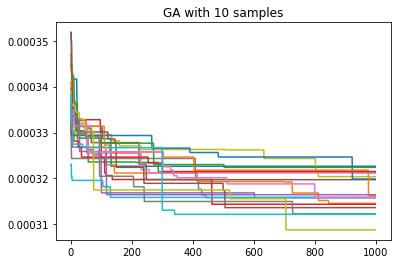

In [160]:
if __name__ == '__main__':
    args = parser.parse_args(args=[])
    main(args)

Show the optimal solution in plot.

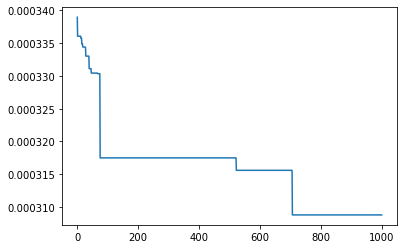

In [169]:
plt.plot(recorded_best_fitness)
f=plt.gcf()
pic_dir = "pics"
f.savefig(os.path.join(pic_dir,'GA_final(2).jpg'),dpi=1000)

Get the layout of the optimal solution.

In [165]:
Best_sols_ever

[array([[1., 1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 1.],
        [1., 0., 1., 1., 1., 1.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 1.]]),
 array([[1., 1., 0., 0., 1., 1.],
        [1., 0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 1.],
        [1., 0., 1., 1., 1., 1.]]),
 array([[0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 1.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
      